<a href="https://colab.research.google.com/github/raptor-ml/docs/blob/master/docs/guides/getting-started-with-labsdk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[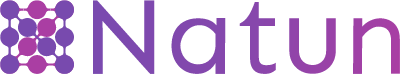](https://raptor.ml)

# LabSDK


Using the LabSDK, Data-scientists can write and experiment with Natun-compatible features(that can run on production) directly from the notebook while developing your model.

When you're done, you can "export" the feature definitions as Kubernetes manifests, and deploy them like any other service in your cluster. This way, you can benefit from the "serverless approach", and **focus on the business-logic**, while Natun is taking care of the production concerns.

## Installing the SDK
Yalla, let's go! In the following two blocks, we install the LabSDK and import it.

In [1]:
!pip install --upgrade natun-labsdk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 12.5 MB/s 


In [2]:
import natun
from natun.stub import *  #<-- this prevents the IDE/Notebookfrom detecting PyExp built-in as errors

## Writing our first features
Our first feature is calculating how many emails an account got over the last 10 hours using the `streaming` builder.

It uses the `clickstream` data-connector the DevOps configured for us.

In [3]:
@natun.register(int, freshness='1m', staleness='10h')
@natun.connector("emails")  #<-- we are decorating our feature with our production data-connector! 😎 
@natun.builder("streaming")
@natun.aggr([natun.AggrFn.Count])
def emails_10h(**req: NatunRequest):
    """email over 10 hours"""
    return 1, req["timestamp"], req['payload']['account_id']

---
> ## ⚠️ *Notice* 
>
> Although it's very tempting to use regular python features(such as imports and packages), it's **not a regular python**
>
> The feature definition above is actually written in [PyExp](https://docs.raptor.ml/docs/reference/pyexp) and will be executed in a production-ready sandboxed runtime.
>
> [Learn more about PyExp »](https://docs.raptor.ml/docs/reference/pyexp)

Let's create another feature that calculates various aggregations against the deal amount.

We're also using here the `streaming` builder against the `deals` data-connector that DevOps configured for us:


In [4]:
@natun.register(int, freshness='1m', staleness='10h')
@natun.connector("deals")
@natun.builder("streaming")
@natun.aggr([natun.AggrFn.Sum, natun.AggrFn.Avg, natun.AggrFn.Max, natun.AggrFn.Min])
def deals_10h(**req: NatunRequest):
    """sum/avg/min/max of deal amount over 10 hours"""
    return req['payload']["amount"], req["timestamp"], req['payload']["account_id"]

Now we can create a *derived feature* that defines the rate between these two features.

Notice that we used the Fully Qualified Name(*FQN*) of the feature, which includes the feature's namespace(*default*).
When querying a feature with an aggregation function, we need to specify the function in the brackets.

In [5]:
@natun.register('headless', freshness='-1', staleness='-1')
def emails_deals(**req: NatunRequest):
    """emails/deal[avg] rate over 10 hours"""
    e, _ = f("emails_10h.default[count]", req['entity_id'])
    d, _ = f("deals_10h.default[avg]", req['entity_id'])
    if e == None or d == None:
        return None
    return e / d

And finally, prepare it as a data set:

In [6]:
@natun.feature_set(register=True)
def deal_prediction():
    return "emails_10h.default[count]", "deals_10h.default[sum]", emails_deals

## Historical Replay
We can "replay" the historical records against our production-ready feature that we have written above for development purposes.

The SDK will run this code locally and allow us to iterate on it quickly.

In [7]:
!pip install pandas pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd

# first, calculate the "root" features
df = pd.read_parquet("https://gist.github.com/AlmogBaku/a1b331615eaf1284432d2eecc5fe60bc/raw/emails.parquet")
emails_10h.replay(df, entity_id_field="account_id")

df = pd.read_csv("https://gist.githubusercontent.com/AlmogBaku/a1b331615eaf1284432d2eecc5fe60bc/raw/deals.csv")
deals_10h.replay(df, entity_id_field="account_id")

# then, we can calculate the derrived features
emails_deals.replay(df, entity_id_field="account_id")

,fqn,entity_id,value,timestamp
0,emails_deals.default,msft,0.002183,2022-01-01 12:00:10+00:00
1,emails_deals.default,msft,0.002316,2022-01-01 13:10:00+00:00
2,emails_deals.default,msft,0.002938,2022-01-01 13:21:00+00:00
3,emails_deals.default,msft,0.002106,2022-01-01 14:03:00+00:00
4,emails_deals.default,msft,0.001714,2022-01-01 14:10:00+00:00
5,emails_deals.default,msft,0.001556,2022-01-01 14:20:00+00:00
6,emails_deals.default,msft,0.001764,2022-01-01 14:30:00+00:00
7,emails_deals.default,msft,0.001980,2022-01-01 14:40:00+00:00
8,emails_deals.default,msft,0.002219,2022-01-01 15:33:00+00:00
9,emails_deals.default,tesla,0.000113,2022-01-01 12:00:00+00:00


---
> ℹ️ **Looking to run Replay at *scale*?** try [Natun Enterprise](mailto:contact@raptor.ml) 🦸‍♂️


## Building our model
To use our set in for our model, we need to query it:

In [9]:
df = deal_prediction.historical_get(since='2020-1-1', until='2022-12-31')
df
# model.fit(df)

,timestamp,entity_id,emails_10h.default[count],deals_10h.default[sum],emails_deals.default
0,2022-01-01 12:00:00+00:00,msft,1.0,458.0,0.002183
1,2022-01-01 12:00:00+00:00,tesla,1.0,8837.0,0.000113
2,2022-01-01 12:20:00+00:00,tesla,2.0,103502.0,0.000039
3,2022-01-01 13:10:00+00:00,msft,2.0,1727.0,0.002316
4,2022-01-01 13:20:00+00:00,msft,3.0,3063.0,0.002938
5,2022-01-01 13:40:00+00:00,tesla,3.0,109966.0,0.000082
6,2022-01-01 14:00:00+00:00,msft,4.0,7599.0,0.002106
7,2022-01-01 14:10:00+00:00,msft,5.0,14583.0,0.001714
8,2022-01-01 14:20:00+00:00,msft,6.0,23132.0,0.001556
9,2022-01-01 14:30:00+00:00,msft,7.0,27775.0,0.001764


## Deployment
That's the fun part! 🤗 Making our features run at scale in production couldn't be easier.

We only need to deploy our feature definitions to the Natun Platform.
You can do that with a preferred CI/CD of your choice, manually via `kubectl` or directly from your Jupyter Notebook(but that's not recommended for real-production environments 🤪)

### Manifest deployment (only use this for production)
We *copy-and-paste* the generated manifests to git, and use the organization's preferred method for deploying Kubernetes manifests (i.e. gitops, jenkins, kustomize, helm, etc.)

In [10]:
natun.manifests()

apiVersion: k8s.raptor.ml/v1alpha1
kind: Feature
metadata:
  name: emails-10h
  namespace: default
  annotations:
    a8r.io/description: "email over 10 hours
spec:
  primitive: string
  freshness: 1m
  staleness: 10h
  aggr:
    - count
  builder:
    kind: streaming
    pyexp: |
      def emails_10h(**req):
          'email over 10 hours'
          return (1, req['timestamp'], req['payload']['account_id'])
---
apiVersion: k8s.raptor.ml/v1alpha1
kind: Feature
metadata:
  name: deals-10h
  namespace: default
  annotations:
    a8r.io/description: "sum/avg/min/max of deal amount over 10 hours
spec:
  primitive: string
  freshness: 1m
  staleness: 10h
  aggr:
    - sum
    - avg
    - max
    - min
  builder:
    kind: streaming
    pyexp: |
      def deals_10h(**req):
          'sum/avg/min/max of deal amount over 10 hours'
          return (req['payload']['amount'], req['timestamp'], req['payload']['account_id'])
---
apiVersion: k8s.raptor.ml/v1alpha1
kind: Feature
metadata:
  name: em

### Direct deployment (for local development)
Alternatively, we can just deploy it on our own directly from python:

1. Make sure you've installed and configured `kubectl` on the notebook device.
2. Then, you can create and upload your manifests directly from the notebook
```python
manifests = natun.manifests(return_str=True)
```
```
!echo "$manifests" | kubectl apply -f -
```

>> We didn't include these blocks as executable since you need to configure your cluster.

## Viola! 🪄
**From now on**, our cluster will collect and build features in production and record the values for historical purposes (so you'll be able to retrain against the production data)